In [158]:
# Systems and Storage
import os
import pickle
import time
from collections import Counter

# Data structures
import pandas as pd
import numpy as np

# Strings
import re
import string

# Model: sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
# Model: TensorFlow
import tensorflow as tf
import tensorflow_hub as hub

# Outputs
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Import Data

In [ ]:
# os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")
os.chdir("/Users/manat/OneDrive/Documents/Tim/MIDS/266_NLP/Final Project")

#load training data
twitter_train = pd.read_excel('./w266_final_project/StanceDataset/train.xlsx')

#load test data
twitter_test = pd.read_excel('./w266_final_project/StanceDataset/test.xlsx')

In [2]:
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [3]:
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


## Elmo Embeddings  

Read in from pre-calculated pickle files (temporary solution)

In [30]:
# ELMO OUTPUTS
with open("./ELMO Outputs v.2/elmo_train.pickle", "rb") as f:
    elmo_train = pickle.load(f)
    
with open("./ELMO Outputs v.2/elmo_test.pickle", "rb") as f:
    elmo_test = pickle.load(f)

In [36]:
elmo_train.keys()

dict_keys(['word_emb', 'sequence_len', 'elmo', 'default', 'lstm_outputs1', 'lstm_outputs2'])

Padding

In [42]:
print("Train shape: " + str(input_dict_train['elmo']['elmo'].shape))
print("Test shape (pre-padding): " + str(input_dict_test['elmo']['elmo'].shape))

print("Test shape (post-padding): " + str(np.pad(input_dict_test['elmo']['elmo'], 
                                                 pad_width = ((0,0),(1,1),(0,0)), 
                                                 mode = 'constant', 
                                                 constant_values = 0).shape))

Train shape: (2914, 32, 1024)
Test shape (pre-padding): (1956, 30, 1024)
Test shape (post-padding): (1956, 32, 1024)


## Pre-Processing  

### Labels

In [121]:
# PREP LABELS FOR NN
stance_train = np.array(twitter_train['Stance'])
stance_test = np.array(twitter_test['Stance'])

# One-hot Encoder
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(stance_train.reshape(-1, 1))
label_categories = enc.categories_[0]

labels_train = enc.transform(stance_train.reshape(-1, 1)).toarray()
labels_test = enc.transform(stance_test.reshape(-1, 1)).toarray()

print(label_categories)
print(labels_train[:5])

['AGAINST' 'FAVOR' 'NONE']
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [122]:
# CHECK resource sizes
print("Train Data")
print("Data shape: " + str(twitter_train.shape))
print("Labels shape: " + str(labels_train.shape))
print("Elmo shape: " + str(elmo_train['elmo'].shape))

Train Data
Data shape: (2914, 5)
Labels shape: (2914, 3)
Elmo shape: (2914, 32, 1024)


### Input Dictionaries

In [123]:
input_dict_train = {}
input_dict_train['data'] = twitter_train
input_dict_train['labels_raw'] = stance_train
input_dict_train['labels'] = labels_train
input_dict_train['elmo'] = elmo_train

input_dict_test = {}
input_dict_test['data'] = twitter_test
input_dict_test['labels_raw'] = stance_test
input_dict_test['labels'] = labels_test
input_dict_test['elmo'] = elmo_test

## Topic subsets

In [177]:
def topic_subset(input_train, input_test, 
                 topics_selected, embed_layer):
        
    # Topics to lower case
    for i in range(0,len(topics_selected)):
        topics_selected[i] = topics_selected[i].lower()
    
    # SUBSET - Boolean series of all rows pertaining to the relevant topics
    matches_train = input_train['data']['Target'].apply(lambda x: x.lower() in topics_selected)
    matches_test = input_test['data']['Target'].apply(lambda x: x.lower() in topics_selected)
    
    # Subset features
    embeddings_train = input_train['elmo'][embed_layer][matches_train,:,:]
    embeddings_test = np.pad(input_test['elmo'][embed_layer], 
                             pad_width = ((0,0),(1,1),(0,0)), 
                             mode = 'constant', 
                             constant_values = 0)[matches_test,:,:]
    
    # Subset labels
    labels_train = input_train['labels'][matches_train,:]
    labels_test = input_test['labels'][matches_test,:]
    
    # Training class counts
    labels_weight_train = np.sum(labels_train, axis = 0) # Counter(input_train['labels_raw'])
    
    # Subset raw test labels for output metrics
    labels_raw_test = input_test['labels_raw'][matches_test]
    
    # Dev Split - NOTE - keras fit function can do this automatically
#     embeddings_train, embeddings_dev, labels_train, labels_dev = train_test_split(embeddings_train, 
#                                                                                   labels_train, 
#                                                                                   test_size = 0.2, random_state = 42)
    
    # Return dictionary
    output_dict = {}
    output_dict['embeddings_train'] = embeddings_train
#     output_dict['embeddings_dev'] = embeddings_dev
    output_dict['embeddings_test'] = embeddings_test
    output_dict['labels_train'] = labels_train
#     output_dict['labels_dev'] = labels_dev
    output_dict['labels_test'] = labels_test
    output_dict['labels_weight_train'] = labels_weight_train
    output_dict['labels_raw_test'] = labels_raw_test
    
    return output_dict

In [178]:
# Atheism
atheism_dict = topic_subset(input_train = input_dict_train,
                            input_test = input_dict_test,
                            topics_selected = ['Atheism'], 
                            embed_layer = 'elmo')

In [179]:
# Check sizes
print("Atheism Subset")
print("Embeddings (train) shape: " + str(atheism_dict['embeddings_train'].shape))
print("Labels (train) shape: " + str(atheism_dict['labels_train'].shape))
# print("Embeddings (dev) shape: " + str(atheism_dict['embeddings_dev'].shape))
# print("Labels (dev) shape: " + str(atheism_dict['labels_dev'].shape))
print("Embeddings (test) shape: " + str(atheism_dict['embeddings_test'].shape))
print("Labels (test) shape: " + str(atheism_dict['labels_test'].shape))
print("Raw Labels (test) shape: " + str(atheism_dict['labels_raw_test'].shape))
print("Class weights (train) shape: " + str(len(atheism_dict['labels_weight_train'])))

Atheism Subset
Embeddings (train) shape: (513, 32, 1024)
Labels (train) shape: (513, 3)
Embeddings (test) shape: (220, 32, 1024)
Labels (test) shape: (220, 3)
Raw Labels (test) shape: (220,)
Class weights (train) shape: 3


## Helper function for model performances

In [149]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.ylim([-0.5, 2.5]) # Fixed values for now
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [114]:
def standard_metrics(true_labels, test_probs, label_titles):
    # Find predicted labels
    test_prob_max = np.argmax(test_probs, axis = 1)

    test_predicts = []
    for i in range(len(test_prob_max)):
        test_predicts.append(label_titles[test_prob_max[i]])
    
    # F1 score
    f1 = f1_score(true_labels, test_predicts, average = 'macro')
    print("F1 macro score:", f1)
    
    # Classification Report
    print(classification_report(y_true = true_labels, 
                                        y_pred = test_predicts,
                                        target_names = label_titles))
    
    # Confusion Matrix plot
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    plt.figure(figsize = (20, 5))
    confusion_plot(confuse, label_titles)
    plt.show()

In [152]:
# Histograms of predicted probabilities
def class_prob_breakdown(true_labels, test_probs, label_titles):
    plt.figure(figsize=(20, 10))

    plt.subplot(2,3,1)
    plt.title("Prob. Dist. - Predicted " + label_titles[0])
    plt.hist([item[0] for item in test_probs])

    plt.subplot(2,3,2)
    plt.title("Prob. Dist. - Predicted " + label_titles[1])
    plt.hist([item[1] for item in test_probs])

    plt.subplot(2,3,3)
    plt.title("Prob. Dist. - Predicted " + label_titles[2])
    plt.hist([item[2] for item in test_probs])

    plt.subplot(2,3,4)
    plt.title("Prob. Dist., by True Label - " + label_titles[0])
    sns.distplot([item[0] for item in test_probs[true_labels==label_titles[0]]], hist = False, label = "True " + label_titles[0])
    sns.distplot([item[0] for item in test_probs[true_labels==label_titles[1]]], hist = False, label = "True " + label_titles[1])
    sns.distplot([item[0] for item in test_probs[true_labels==label_titles[2]]], hist = False, label = "True " + label_titles[2])

    plt.subplot(2,3,5)
    plt.title("Prob. Dist., by True Label - " + label_titles[1])
    sns.distplot([item[1] for item in test_probs[true_labels==label_titles[0]]], hist = False, label = "True " + label_titles[0])
    sns.distplot([item[1] for item in test_probs[true_labels==label_titles[1]]], hist = False, label = "True " + label_titles[1])
    sns.distplot([item[1] for item in test_probs[true_labels==label_titles[2]]], hist = False, label = "True " + label_titles[2])
    
    plt.subplot(2,3,6)
    plt.title("Prob. Dist., by True Label - " + label_titles[2])
    sns.distplot([item[2] for item in test_probs[true_labels==label_titles[0]]], hist = False, label = "True " + label_titles[0])
    sns.distplot([item[2] for item in test_probs[true_labels==label_titles[1]]], hist = False, label = "True " + label_titles[1])
    sns.distplot([item[2] for item in test_probs[true_labels==label_titles[2]]], hist = False, label = "True " + label_titles[2])

    plt.show()

## Define model

In [188]:
def lstm_model(activation_function_lstm = 'tanh', 
                optimizer = 'adam', 
                kernel_initializer = tf.keras.initializers.he_normal(seed=115), 
                bias_initializer = 'zeros'):
    
    # Input layer(s)
    input_vectors = tf.keras.layers.Input(shape = (32,1024), 
                                          name = "input_numbers")
    
    # LSTM layer
    # TS NOTE: LSTM units set to 5, don't we want some factor of 3 (3 output classes)?
    lstm1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units = 6, 
                             input_shape = (32,1024),
                             activation = activation_function_lstm,
                             recurrent_activation = activation_function_lstm,
                             kernel_initializer = kernel_initializer,
                             recurrent_initializer = kernel_initializer,
                             bias_initializer = bias_initializer,
                             dropout = 0.5,
                             name = 'lstm1'), 
        merge_mode = 'concat')
    
    # RUN LSTM layer 1
    lstm_output1 = lstm1(input_vectors)
    
    # Classification layer (softmax since we have 3 classes)
    classification_layer = tf.keras.layers.Dense(3, 
                                                 activation = 'softmax', 
                                                 name = 'classification') 
    classification_output = classification_layer(lstm_output1) 

    # Build and compile model
    lstm_mod = tf.keras.models.Model(input_vectors, classification_output)
    
    lstm_mod.compile(loss = 'categorical_crossentropy', 
                     optimizer = optimizer, 
                     metrics = ['categorical_accuracy'])
    
    return lstm_mod

lstm_mod = lstm_model()
lstm_mod.summary()    

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_numbers (InputLayer)   [(None, 32, 1024)]        0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 12)                49488     
_________________________________________________________________
classification (Dense)       (None, 3)                 39        
Total params: 49,527
Trainable params: 49,527
Non-trainable params: 0
_________________________________________________________________


# Run LSTM on 'ELMO' outputs

In [189]:
lstm_atheism = lstm_model()

# Train model
lstm_atheism.fit(
    x = atheism_dict['embeddings_train'],
    y = atheism_dict['labels_train'],
    epochs = 100,
    batch_size = 100,
    verbose = 2,
    # TS ADDs
    validation_split = 0.2,
    shuffle = True,
    class_weight = atheism_dict['labels_weight_train']
)

# Predictions
atheism_test_pred = lstm_atheism.predict(atheism_dict['embeddings_test'])

Train on 410 samples, validate on 103 samples
Epoch 1/100
410/410 - 2s - loss: 1.1324 - categorical_accuracy: 0.3366 - val_loss: 1.0523 - val_categorical_accuracy: 0.4563
Epoch 2/100
410/410 - 1s - loss: 1.1181 - categorical_accuracy: 0.3756 - val_loss: 1.0327 - val_categorical_accuracy: 0.5049
Epoch 3/100
410/410 - 1s - loss: 1.1082 - categorical_accuracy: 0.4098 - val_loss: 0.9838 - val_categorical_accuracy: 0.6408
Epoch 4/100
410/410 - 1s - loss: 1.0710 - categorical_accuracy: 0.4537 - val_loss: 0.9340 - val_categorical_accuracy: 0.7379
Epoch 5/100
410/410 - 1s - loss: 1.0727 - categorical_accuracy: 0.4561 - val_loss: 0.8904 - val_categorical_accuracy: 0.7864
Epoch 6/100
410/410 - 1s - loss: 1.0467 - categorical_accuracy: 0.4659 - val_loss: 0.8640 - val_categorical_accuracy: 0.8058
Epoch 7/100
410/410 - 1s - loss: 1.0475 - categorical_accuracy: 0.4902 - val_loss: 0.8385 - val_categorical_accuracy: 0.8252
Epoch 8/100
410/410 - 1s - loss: 1.0314 - categorical_accuracy: 0.5000 - val_lo

Epoch 66/100
410/410 - 2s - loss: 0.7365 - categorical_accuracy: 0.7024 - val_loss: 0.7121 - val_categorical_accuracy: 0.6990
Epoch 67/100
410/410 - 2s - loss: 0.7380 - categorical_accuracy: 0.6585 - val_loss: 0.6611 - val_categorical_accuracy: 0.7476
Epoch 68/100
410/410 - 2s - loss: 0.7236 - categorical_accuracy: 0.7000 - val_loss: 0.6951 - val_categorical_accuracy: 0.7087
Epoch 69/100
410/410 - 2s - loss: 0.7071 - categorical_accuracy: 0.7122 - val_loss: 0.7132 - val_categorical_accuracy: 0.6990
Epoch 70/100
410/410 - 2s - loss: 0.6930 - categorical_accuracy: 0.7098 - val_loss: 0.7160 - val_categorical_accuracy: 0.6990
Epoch 71/100
410/410 - 2s - loss: 0.7108 - categorical_accuracy: 0.6976 - val_loss: 0.7563 - val_categorical_accuracy: 0.6408
Epoch 72/100
410/410 - 2s - loss: 0.6879 - categorical_accuracy: 0.7341 - val_loss: 0.7464 - val_categorical_accuracy: 0.6699
Epoch 73/100
410/410 - 2s - loss: 0.6892 - categorical_accuracy: 0.7122 - val_loss: 0.7732 - val_categorical_accuracy:

F1 macro score: 0.5216141514648976
              precision    recall  f1-score   support

     AGAINST       0.82      0.89      0.85       160
       FAVOR       0.54      0.22      0.31        32
        NONE       0.38      0.43      0.40        28

    accuracy                           0.74       220
   macro avg       0.58      0.51      0.52       220
weighted avg       0.72      0.74      0.72       220



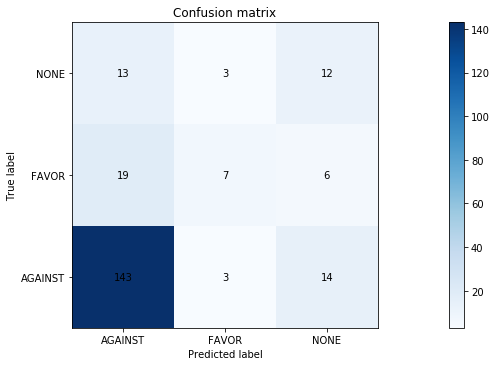

In [190]:
# Output Metrics
standard_metrics(true_labels = atheism_dict['labels_raw_test'], 
                 test_probs = atheism_test_pred,
                 label_titles = label_categories)

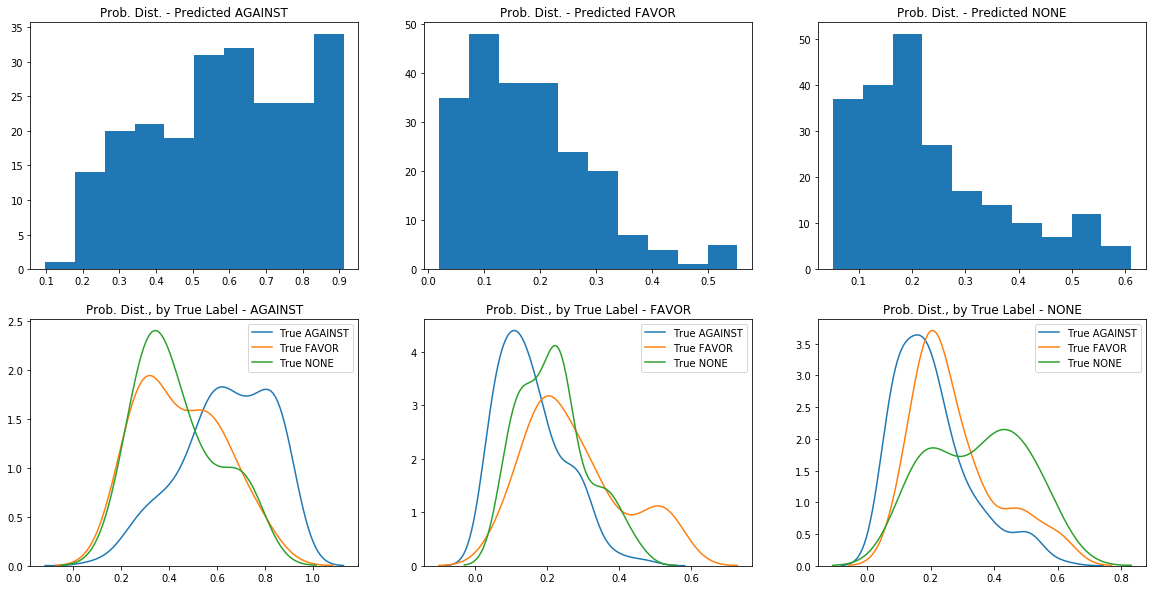

In [191]:
class_prob_breakdown(true_labels = atheism_dict['labels_raw_test'], 
                     test_probs = atheism_test_pred,
                     label_titles = label_categories)

In [126]:
target_categories = twitter_train['Target'].unique()
target_categories

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement'],
      dtype=object)